## LeNet5 MNIST

In [0]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
import numpy as np


%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
T = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [0]:
train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [0]:
print('Размер даннных изображений на тренировку: ', train_data.data.shape)
print('Размер меток на тренировку: ', train_data.targets.shape)
print('Размер даннных изображений на тестирование: ', test_data.data.shape)
print('Размер меток на тестирование: ', test_data.targets.shape)

Размер даннных изображений на тренировку:  torch.Size([60000, 28, 28])
Размер меток на тренировку:  torch.Size([60000])
Размер даннных изображений на тестирование:  torch.Size([10000, 28, 28])
Размер меток на тестирование:  torch.Size([10000])


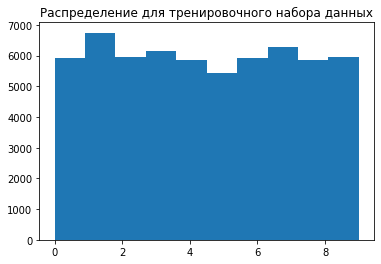

In [0]:
plt.title('Распределение для тренировочного набора данных')
plt.hist(train_data.targets);

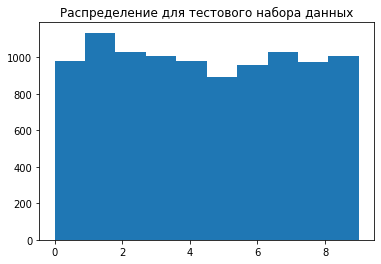

In [0]:
plt.title('Распределение для тестового набора данных')
plt.hist(test_data.targets);

In [0]:
num, height, width = np.array(train_data.data).shape
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
print(img_min, img_max, img_norm_mean, img_std)

0 255 0.1306604762738429 0.3081078038564622


In [0]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((img_norm_mean,), (img_std,)) 
])
train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [0]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 6, 4, 7, 6, 0, 0, 5])


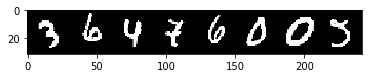

In [0]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5,
                               padding=0)        
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)        
        self.fc1 = nn.Linear(in_features=8*5*5,
                             out_features=120) 
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84, 
                             out_features=10)

    def forward(self, x):        
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)        
        x = x.view(-1, 8 * 5 * 5)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

model = LeNet()
model.to(device)        

LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [0]:
torch.manual_seed(42)

In [0]:
epochs = 20
log_interval = 1000
iterations = len(train_loader.dataset)//batch_size

x = list(range(1, epochs + 1))
training_loss_list = []
validation_loss_list = []
validation_accuracy_list = []


In [0]:
print("Размер даннных изображений на тренировку: ", len(train_loader.dataset))
print("Размер меток на валидацию: ", len(test_loader.dataset))

Размер даннных изображений на тренировку:  60000
Размер меток на валидацию:  10000


In [0]:
for epoch in range(epochs):
    model.train()
    
    epoch_training_loss = 0
    accuracy = 0
    num_batches = 0
            
    for batch_idx, training_batch in enumerate(train_loader, 0):        
        inputs, labels = training_batch[0].to(device), training_batch[1].to(device)
                
        optimizer.zero_grad()
        outputs = model(inputs)      
        loss = loss_function(outputs, labels)      
        loss.backward()        
        optimizer.step()        
        epoch_training_loss += loss.item()
        num_batches+=1
              
        if batch_idx % log_interval == log_interval - 1:
            
            validation_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                model.eval()
                for val_data in test_loader:
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_inputs)
                    
                    val_loss = loss_function(val_outputs, val_labels)
                    validation_loss += val_loss.item()
                                        
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()            
            model.train()
                    
    epoch_training_loss /= iterations
    validation_loss /= log_interval
    validation_accuracy = 100*correct/total    
    
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)    

    print("Epoch: %2d, train_loss: %.3f, val_loss: %.3f, val_acc: %.3f" % (epoch + 1,epoch_training_loss,validation_loss,validation_accuracy))

Epoch:  1, train_loss: 1.763, val_loss: 0.687, val_acc: 83.190
Epoch:  2, train_loss: 0.325, val_loss: 0.276, val_acc: 92.980
Epoch:  3, train_loss: 0.181, val_loss: 0.182, val_acc: 95.470
Epoch:  4, train_loss: 0.132, val_loss: 0.138, val_acc: 96.700
Epoch:  5, train_loss: 0.108, val_loss: 0.109, val_acc: 97.360
Epoch:  6, train_loss: 0.093, val_loss: 0.098, val_acc: 97.640
Epoch:  7, train_loss: 0.083, val_loss: 0.101, val_acc: 97.550
Epoch:  8, train_loss: 0.075, val_loss: 0.080, val_acc: 98.030
Epoch:  9, train_loss: 0.069, val_loss: 0.083, val_acc: 97.970
Epoch: 10, train_loss: 0.064, val_loss: 0.072, val_acc: 98.080
Epoch: 11, train_loss: 0.060, val_loss: 0.063, val_acc: 98.300
Epoch: 12, train_loss: 0.056, val_loss: 0.065, val_acc: 98.270
Epoch: 13, train_loss: 0.053, val_loss: 0.073, val_acc: 98.110
Epoch: 14, train_loss: 0.050, val_loss: 0.053, val_acc: 98.660
Epoch: 15, train_loss: 0.048, val_loss: 0.059, val_acc: 98.360
Epoch: 16, train_loss: 0.046, val_loss: 0.050, val_acc:

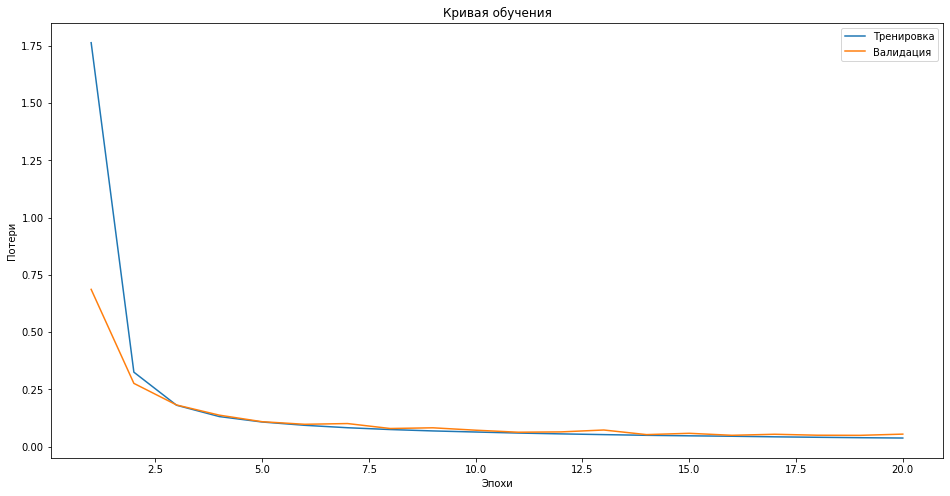

In [0]:
plt.figure(figsize=(16,8))
plt.title("Кривая обучения")
plt.plot(x, training_loss_list, label= 'Тренировка')
plt.plot(x, validation_loss_list, label= 'Валидация')
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend();

In [0]:
def show_features(features):
    if len(features.shape) < 4:
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1)
                plt.imshow(feature.numpy())

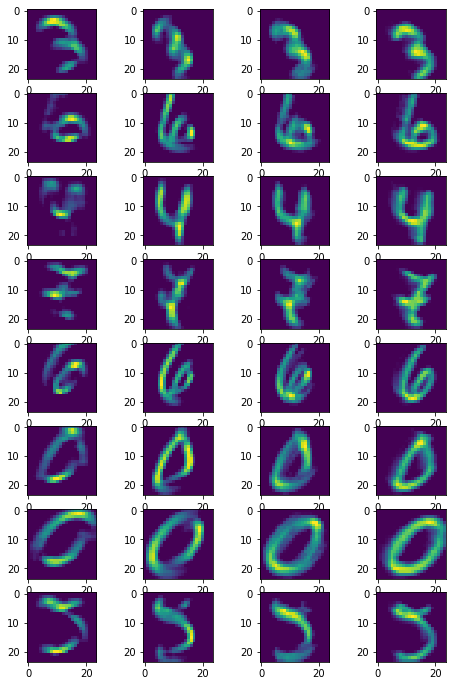

In [0]:
plt.figure(figsize=(8,12))
show_features(model.features_1(images.to(device)).detach().cpu())

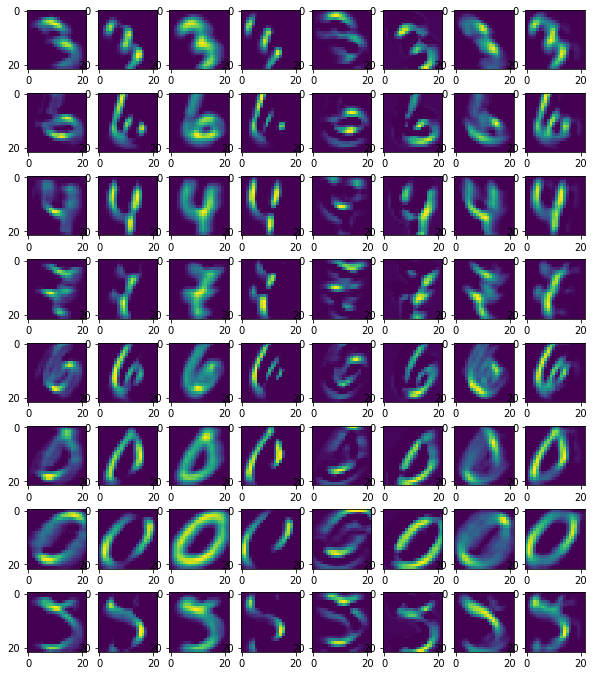

In [0]:
plt.figure(figsize=(10,12))
show_features(model.features_2(images.to(device)).detach().cpu())

# Ошибочные предсказания

In [0]:
import pandas as pd
import seaborn as sns

nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

confusion_matrix = confusion_matrix.numpy()
confusion_matrix = confusion_matrix.astype('int32')

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('Верная метка')
    plt.xlabel('Предсказанная метка')
    return fig

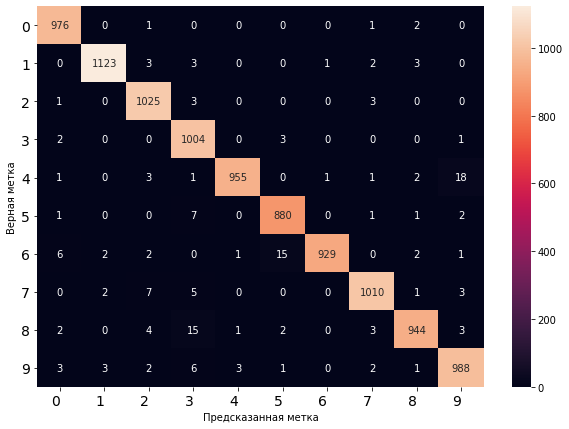

In [0]:
fig = print_confusion_matrix(confusion_matrix, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], figsize = (10,7), fontsize=14)

## Ошибки

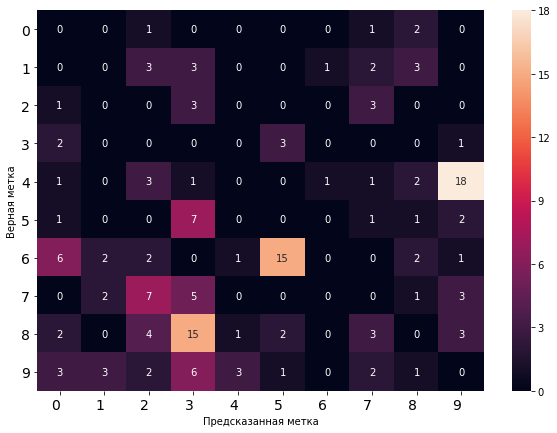

In [0]:
confusion_matrix[np.diag_indices_from(confusion_matrix)] = 0
fig = print_confusion_matrix(confusion_matrix, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], figsize = (10,7), fontsize=14)

In [0]:
errors_inputs = []
errors_labels = []
errors_predicted = []

with torch.no_grad():
    model.eval()
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        mask = torch.nonzero(predicted != labels)
        errors_inputs.extend(inputs[mask])
        errors_labels.extend(labels[mask])
        errors_predicted.extend(predicted[mask])

In [0]:
numbers_list = [0,1,2,3,4,5,6,7,8,9]
def plot_error(idx):
    
    p = model.forward(errors_inputs[idx])
    p = torch.softmax(p, dim = 1)
    p = p.cpu().data.numpy().squeeze()
    
    print("GT: %d" % (errors_labels[idx]))
    print("Predict: %d" % (errors_predicted[idx]))
    plt.figure(figsize=(4,4))
    plt.imshow(errors_inputs[idx].resize_(1,28,28).cpu().numpy().squeeze(), cmap = 'gray')
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.bar(numbers_list, p)
    plt.xticks(numbers_list)
    plt.ylim(0, 1)
    plt.ylabel('Вероятность')
    plt.xlabel('Метка')
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_1(errors_inputs[idx].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_2(errors_inputs[idx].unsqueeze(0).to(device)).detach().cpu())
    plt.show()

GT: 4
Predict: 9


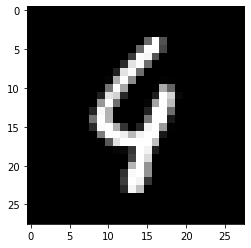

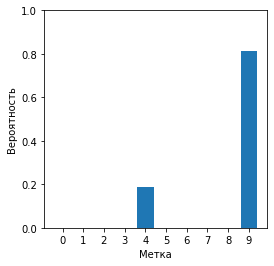

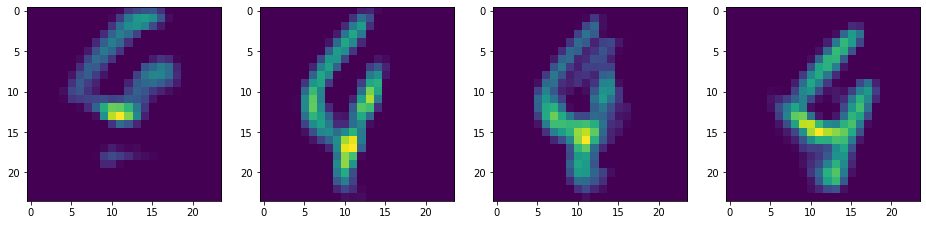

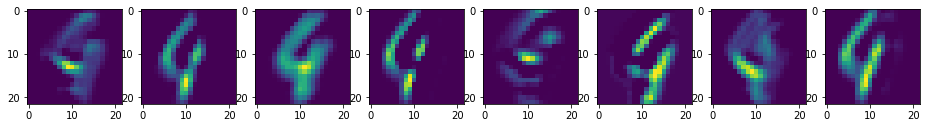

GT: 8
Predict: 3


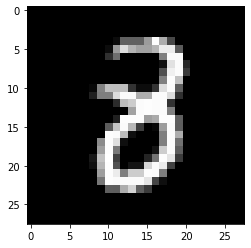

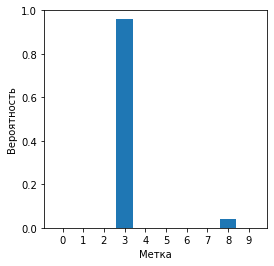

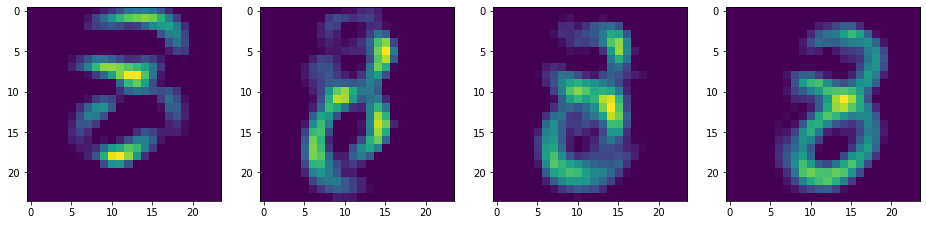

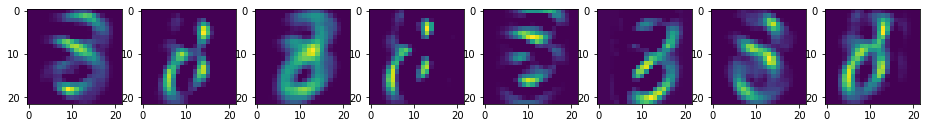

GT: 6
Predict: 5


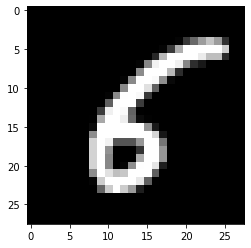

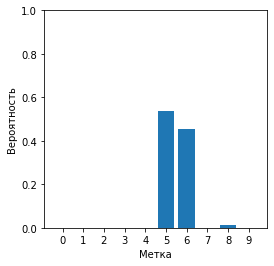

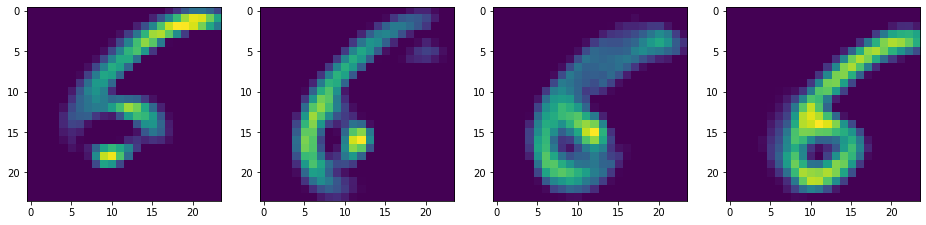

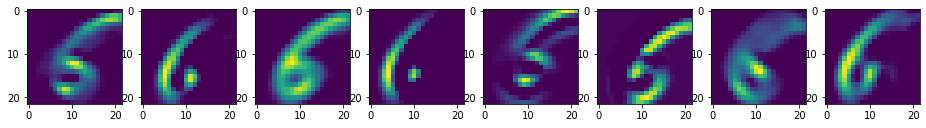

GT: 4
Predict: 2


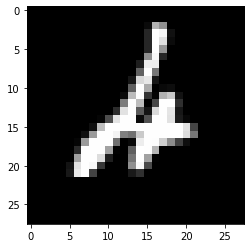

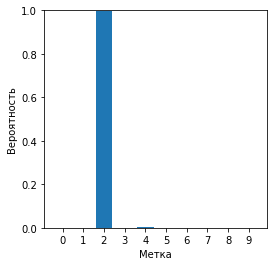

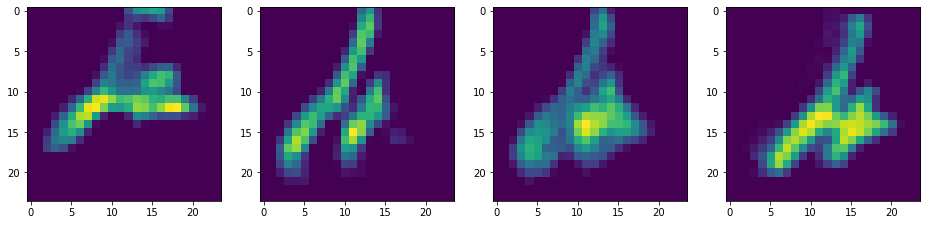

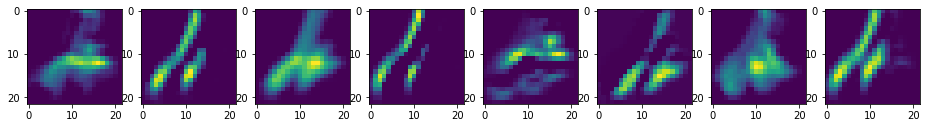

GT: 6
Predict: 0


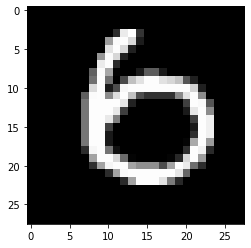

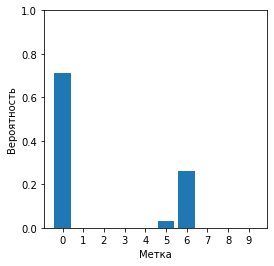

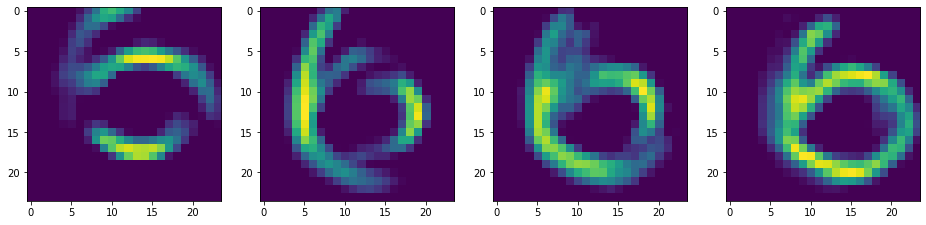

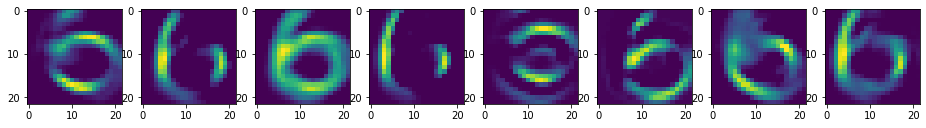

GT: 5
Predict: 3


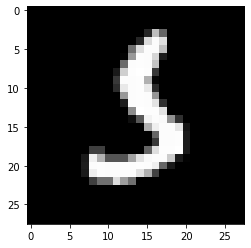

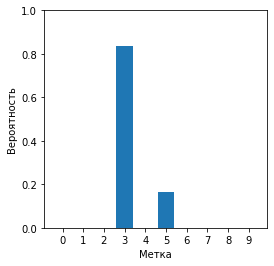

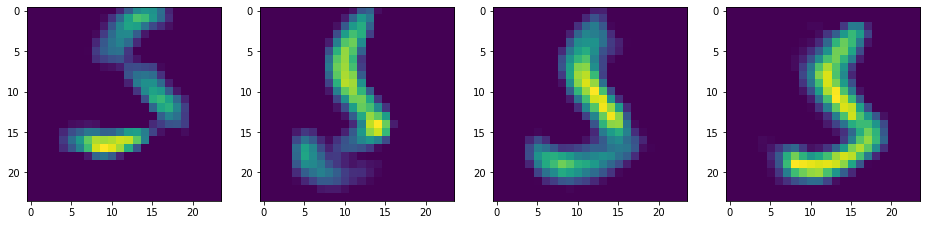

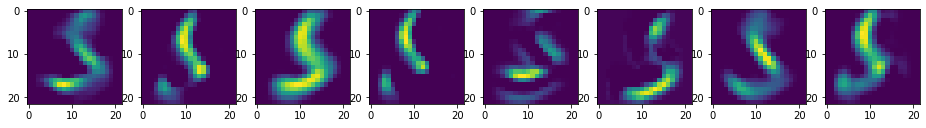

GT: 6
Predict: 0


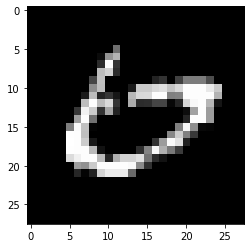

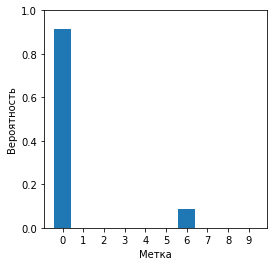

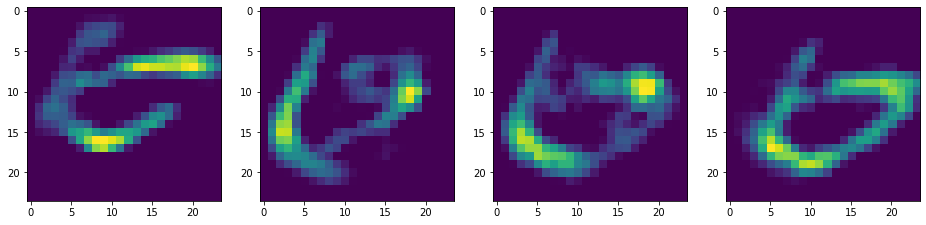

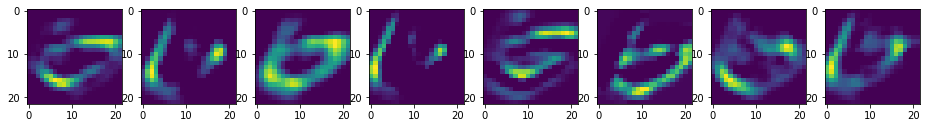

GT: 4
Predict: 9


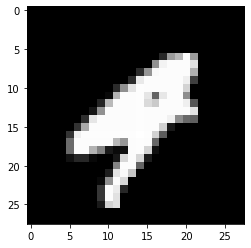

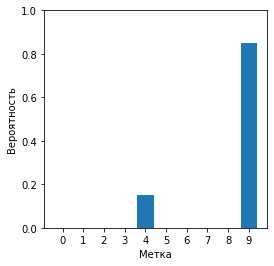

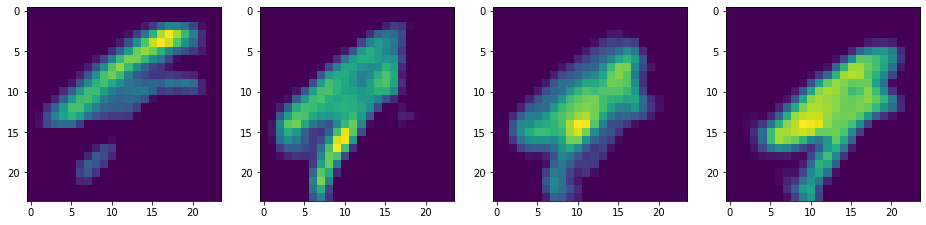

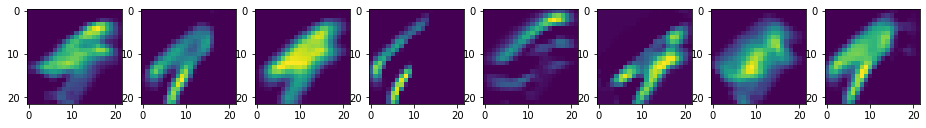

GT: 3
Predict: 5


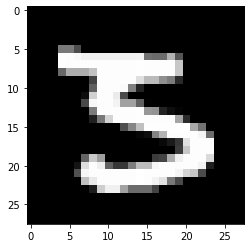

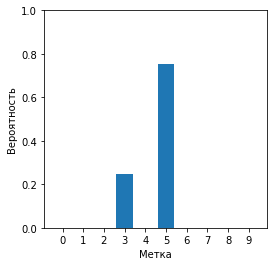

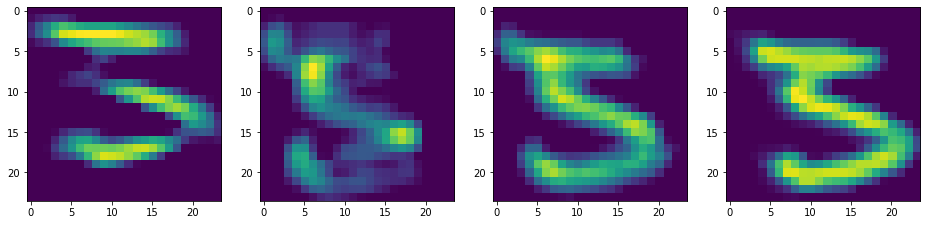

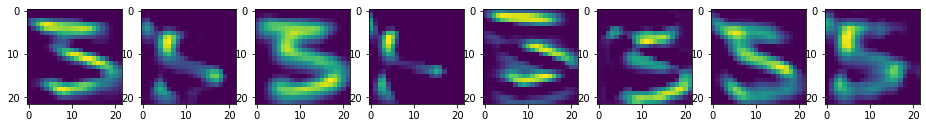

GT: 8
Predict: 7


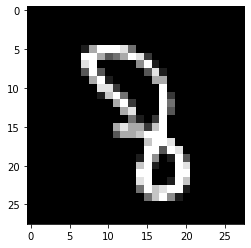

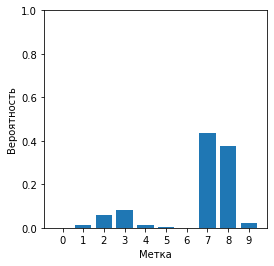

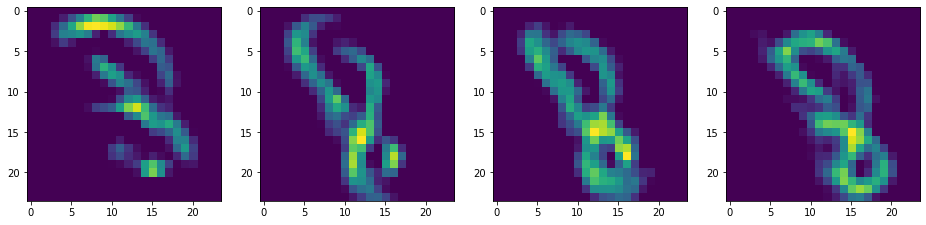

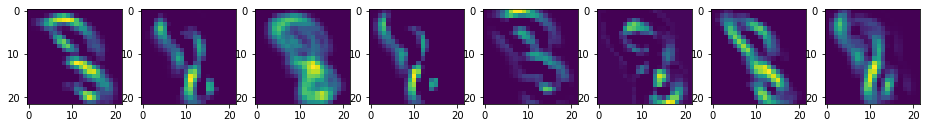

In [0]:
for i in range(10):
    plot_error(i)